In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer 

#from pdpbox import pdp, info_plots

import matplotlib.pyplot as plt
import seaborn as sns

import eli5
from eli5.sklearn import PermutationImportance

import pickle

sns.set_style(style="ticks")
sns.set_palette(sns.color_palette("Dark2"))

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True 
plt.rcParams["xtick.alignment"] = 'center'
plt.rcParams["ytick.alignment"] = 'center'

from os.path import isfile

#print(plt.rcParams.keys())

**Вспомогательные функции и определения.**

In [2]:
colors = {
    0: 'orange',
    1: 'green',
}

labels = {
    0: 'Healthy',
    1: 'Sick'
}

n_class = 2

col_names = [
    'age', 'sex', 'chest_pain_type', 'rst_blood_pressure', 'serum_cholestoral', 'fasting_blood_sugar', 
    'rst_ecg_results', 'max_heart_rate', 'exercise_induced_angina', 'depression_induced_by_exercise', 
    'slope_of_peak_exercise', 'number_of_major_vessels', 'thalassemia', 'healthy', 'health_state'
]

Я решил использовать более-менее полные имена, чтобы "понимать" их значение. Сокращения лично мне понимать крайне сложно.

In [3]:
def plot_confusion_matrix(matrix: np.array, fig_size: tuple):
    f, ax = plt.subplots(figsize=fig_size)
    
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    g = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
    g.set_yticklabels(labels=g.get_yticklabels(), va='center')
    
    return g

In [4]:
def plot_roc(predict_proba: np.array, test: np.array, name: str, n_class: int, colors: list, labels: list, fig_size: tuple):
    fp, tp, thr = {}, {}, {}
    
    f, ax = plt.subplots(1, figsize=fig_size)
    plt.title(name)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    for i in range(n_class):
        fp[i], tp[i], thr[i] = roc_curve(test, predict_proba[:,i], pos_label=i)
        plt.plot(fp[i], tp[i], linestyle='--',color=colors[i], label=labels[i])
    
    plt.show()

**Импорт данных**

In [5]:
exclude_lines = [i for i, line in enumerate(open('./data/src/cleve.mod')) if line.startswith('%')]

src_cleve_df = pd.read_csv(
    filepath_or_buffer='./data/src/cleve.mod',
    delimiter=' ',
    names=col_names,
    skiprows=exclude_lines,
    skipinitialspace=True,
    na_values=['?', -9]
)

In [6]:
src_cleve_df.head()

,age,sex,chest_pain_type,rst_blood_pressure,serum_cholestoral,fasting_blood_sugar,rst_ecg_results,max_heart_rate,exercise_induced_angina,depression_induced_by_exercise,slope_of_peak_exercise,number_of_major_vessels,thalassemia,healthy,health_state
0,63.0,male,angina,145.0,233.0,true,hyp,150.0,fal,2.3,down,0.0,fix,buff,H
1,67.0,male,asympt,160.0,286.0,fal,hyp,108.0,true,1.5,flat,3.0,norm,sick,S2
2,67.0,male,asympt,120.0,229.0,fal,hyp,129.0,true,2.6,flat,2.0,rev,sick,S1
3,37.0,male,notang,130.0,250.0,fal,norm,187.0,fal,3.5,down,0.0,norm,buff,H
4,41.0,fem,abnang,130.0,204.0,fal,hyp,172.0,fal,1.4,up,0.0,norm,buff,H


In [7]:
src_cleve_df.isna().sum()

age                               0
sex                               0
chest_pain_type                   0
rst_blood_pressure                0
serum_cholestoral                 0
fasting_blood_sugar               0
rst_ecg_results                   0
max_heart_rate                    0
exercise_induced_angina           0
depression_induced_by_exercise    0
slope_of_peak_exercise            0
number_of_major_vessels           5
thalassemia                       2
healthy                           0
health_state                      0
dtype: int64

In [8]:
src_cleve_df.shape

(303, 15)

In [9]:
sex = {
    'male': 1,
    'fem':  0
}

# chest pain type
cp = {
    'angina': 1, #typical angina
    'abnang': 2, #atypical angina 
    'notang': 3, #non-anginal pain
    'asympt': 4  #asymptomatic
}

#fasting blood sugar > 120 mg/dl
fbs = {
    'fal':  0,
    'true': 1
}

#resting electrocardiographic results
restecg = {
    'norm': 0, #normal
    'abn':  1, #having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    'hyp':  2  #showing probable or definite left ventricular hypertrophy by Estes' criteria
}

#exercise induced angina (1 = yes; 0 = no)
exang = {
    'fal':  0,
    'true': 1    
}
#the slope of the peak exercise ST segment
slope = {
    'up':   1,
    'flat': 2,
    'down': 3
}


thal = {
    'norm': 3, #normal
    'fix':  6, #fixed defect
    'rev':  7  #reversable defect
}
        
healthy = {
    'buff': 0,
    'sick': 1
}

health_state = {
    'H':  0,
    'S1': 1,
    'S2': 2,
    'S3': 3,
    'S4': 4,
}

In [10]:
X = pd.DataFrame()

X['age'] = src_cleve_df.dropna()['age']
X['sex'] = [sex[x] for x in src_cleve_df.dropna()['sex']]
X['chest_pain_type'] = [cp[x] for x in src_cleve_df.dropna()['chest_pain_type']]
X['rst_blood_pressure'] = src_cleve_df.dropna()['rst_blood_pressure']
X['serum_cholestoral'] = src_cleve_df.dropna()['serum_cholestoral']
X['fasting_blood_sugar'] = [fbs[x] for x in src_cleve_df.dropna()['fasting_blood_sugar']]
X['rst_ecg_results'] = [restecg[x] for x in src_cleve_df.dropna()['rst_ecg_results']]
X['max_heart_rate'] = src_cleve_df.dropna()['max_heart_rate']
X['exercise_induced_angina'] = [exang[x] for x in src_cleve_df.dropna()['exercise_induced_angina']]
X['depression_induced_by_exercise'] = src_cleve_df.dropna()['depression_induced_by_exercise']
X['slope_of_peak_exercise'] = [slope[x] for x in src_cleve_df.dropna()['slope_of_peak_exercise']]
X['number_of_major_vessels'] = src_cleve_df.dropna()['number_of_major_vessels']
X['thalassemia'] = [thal[x] for x in src_cleve_df.dropna()['thalassemia']]

y = np.array(
    [healthy[x] for x in src_cleve_df.dropna()['healthy']]
)

X['healthy'] = y
X['health_state'] = [health_state[x] for x in src_cleve_df.dropna()['health_state']]

In [11]:
X.head()

,age,sex,chest_pain_type,rst_blood_pressure,serum_cholestoral,fasting_blood_sugar,rst_ecg_results,max_heart_rate,exercise_induced_angina,depression_induced_by_exercise,slope_of_peak_exercise,number_of_major_vessels,thalassemia,healthy,health_state
0,63.0,1,1,145.0,233.0,1,2,150.0,0,2.3,3,0.0,6,0,0
1,67.0,1,4,160.0,286.0,0,2,108.0,1,1.5,2,3.0,3,1,2
2,67.0,1,4,120.0,229.0,0,2,129.0,1,2.6,2,2.0,7,1,1
3,37.0,1,3,130.0,250.0,0,0,187.0,0,3.5,3,0.0,3,0,0
4,41.0,0,2,130.0,204.0,0,2,172.0,0,1.4,1,0.0,3,0,0


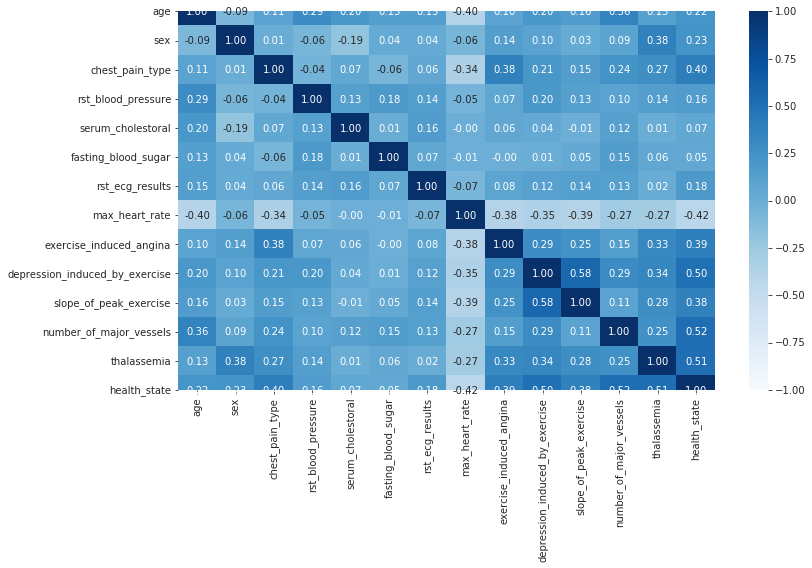

In [12]:
a = sns.heatmap(data=X.loc[:, X.columns != 'healthy'].corr(), annot=True, fmt=".2f", cmap='Blues', vmin=-1.0, vmax=1.0, center=0.0)

Интересно, что максимальный пульс неплохо связан почти со всеми остальными параметрами.

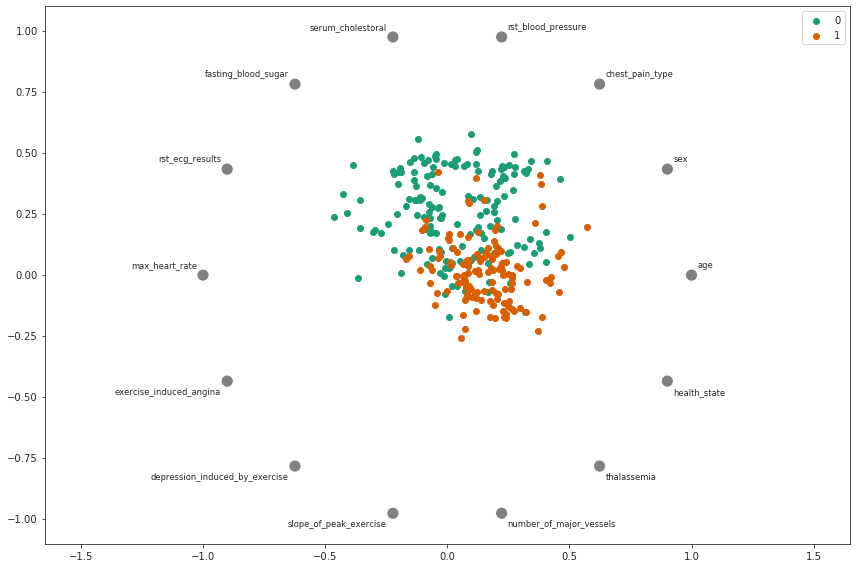

In [13]:
f, ax = plt.subplots(figsize=(12, 8))
a = pd.plotting.radviz(frame=X, class_column='healthy', color=sns.color_palette())

Ничего особенного в данных нет. 

**Модель**

Попробую опорные вектора. Никакого особого смысла именно в этом алгоритме нет. Мне просто нужна базовая модель.

In [14]:
X_ = X.drop(['healthy', 'health_state'], axis=1)
y_ = y

X_ = pd.DataFrame(StandardScaler().fit_transform(X_), columns=X_.columns)

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, shuffle=True, stratify=y_, random_state=42)

Подбирать гиперпараметры буду без изысков, полным перебором вариантов.

In [15]:
svm_result = None

if isfile("./data/models/model_svm.pkl"):
    with open("./data/models/model_svm.pkl", "rb") as m_file:
        svm_result = pickle.load(m_file)
else:
    model_svm = SVC(decision_function_shape='ovr', probability=True)
    
    c_values = np.arange(0.05, 1, 0.05)
    gamma_p = ['scale', 'auto']
    degree_p = np.arange(0.05, 1, 0.05)
    coef0_p = np.arange(0, 1, 0.1)
    
    params = [
        {'kernel': ['linear'], 'C': c_values},
        {'kernel': ['poly'], 'C': c_values, 'degree': degree_p, 'gamma': gamma_p, 'coef0': coef0_p},
        {'kernel': ['rbf'], 'C': c_values, 'gamma': gamma_p},
        {'kernel': ['sigmoid'], 'C': c_values, 'gamma': gamma_p, 'coef0': coef0_p}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_svm, param_grid=params, n_jobs=-1, cv=cross_val, scoring='accuracy',error_score=0)
    svm_result = grid_search.fit(X_train, y_train)
    
    with open("./data/models/model_svm.pkl", "wb") as m_file:
        pickle.dump(svm_result, m_file)

In [16]:
predict_svc = svm_result.best_estimator_.predict_proba(X_test)
print('AUC for SVC :\t{:.4f}'.format(roc_auc_score(y_test, predict_svc[:,1])))
print("\nModels hyperparameters are: {}".format(svm_result.best_params_))

AUC for SVC :	0.8761

Models hyperparameters are: {'C': 0.2, 'coef0': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}


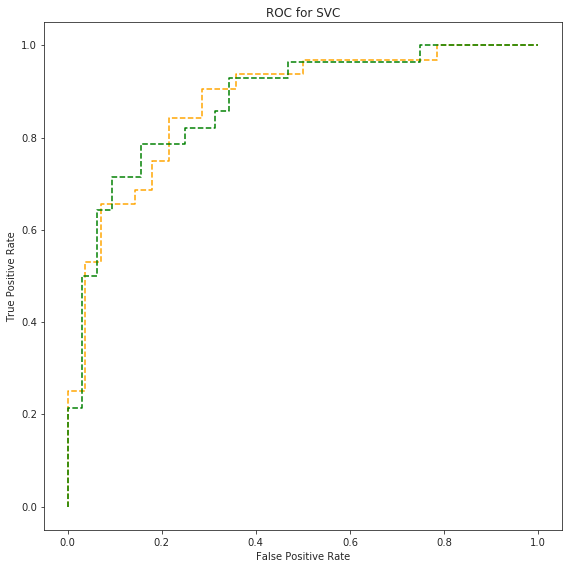

In [17]:
plot_roc(svm_result.best_estimator_.predict_proba(X_test), y_test, 'ROC for SVC', 2, colors, labels, (8, 8))

ROC-AUC получились неплохие. Не идеальные, но близкие к очень хорошим.

In [18]:
print(confusion_matrix(y_test, svm_result.best_estimator_.predict(X_test)))

[[27  5]
 [ 7 21]]


In [19]:
svc_result_perm = PermutationImportance(svm_result.best_estimator_, random_state=42).fit(X_test, y_test)
eli5.show_weights(svc_result_perm, feature_names=X_.columns.values)

Weight,Feature
0.0333 ± 0.0471,number_of_major_vessels
0.0200 ± 0.0442,chest_pain_type
0.0200 ± 0.0327,max_heart_rate
0.0167 ± 0.0211,exercise_induced_angina
0.0067 ± 0.0618,thalassemia
0.0067 ± 0.0163,rst_ecg_results
0.0033 ± 0.0327,sex
0.0000 ± 0.0211,rst_blood_pressure
0 ± 0.0000,slope_of_peak_exercise
0 ± 0.0000,age


In [20]:
#features_to_plot = ['number_of_major_vessels', 'chest_pain_type', 'max_heart_rate', 'exercise_induced_angina', 'thalassemia', 'rst_ecg_results', 'sex']

#pdp_goals = pdp.pdp_isolate(model=svm_result.best_estimator_, dataset=X_test, model_features=col_names[:13:], feature='sex')
#pdp.pdp_plot(pdp_goals, 'sex')
#plt.show()

In [21]:
result = permutation_importance(svm_result.best_estimator_, X_train, y_train, n_repeats=20, random_state=42)

In [22]:
svc_pi = pd.DataFrame()
svc_pi['feature_names'] = col_names[:13:]
svc_pi['permutation_mean'] = result.importances_mean
svc_pi['permutation_std'] = result.importances_std
svc_pi.sort_values(by='permutation_mean', ascending=False, inplace=True)

In [23]:
svc_pi

,feature_names,permutation_mean,permutation_std
12,thalassemia,0.071186,0.016981
11,number_of_major_vessels,0.055720,0.017638
2,chest_pain_type,0.040890,0.010574
7,max_heart_rate,0.024788,0.008397
9,depression_induced_by_exercise,0.017797,0.008949
8,exercise_induced_angina,0.017161,0.010591
1,sex,0.016737,0.007024
10,slope_of_peak_exercise,0.008898,0.007203
3,rst_blood_pressure,0.005932,0.006619
6,rst_ecg_results,0.002966,0.005207


In [24]:
predict_svc = svm_result.best_estimator_.predict_proba(X_test)


In [25]:
y_thr_06 = []
for val in predict_svc:
    if val[0] >= 0.75:
        y_thr_06.append(0)
    else:
        y_thr_06.append(1)

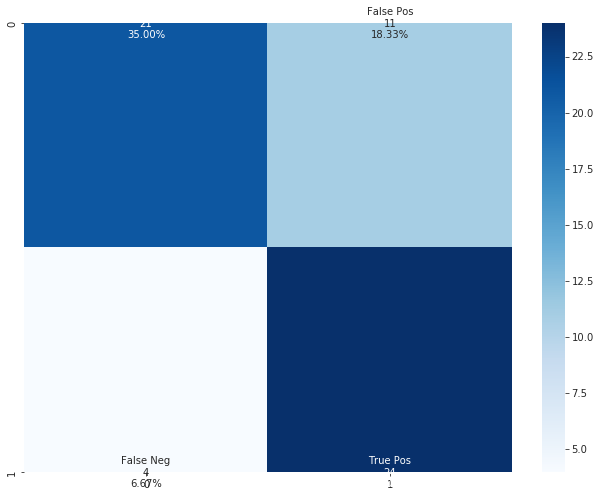

In [26]:
a = plot_confusion_matrix(confusion_matrix(y_test, y_thr_06), (9, 7))

In [27]:
pred = pd.DataFrame()
pred['g_true'] = y_test
pred['pred'] = svm_result.best_estimator_.predict(X_test)
dif = []

for index, row in pred.iterrows():
    if row['g_true'] != row['pred']:
        dif.append(index)

pred.iloc[dif]

,g_true,pred
20,0,1
23,0,1
27,1,0
31,1,0
32,1,0
39,1,0
44,0,1
49,0,1
54,1,0
55,1,0


In [28]:
explainer = LimeTabularExplainer(
    X_test,
    feature_names=X_test.columns, 
    class_names=['healthy', 'sick'], 
    discretize_continuous=False, 
    verbose=True
)

In [29]:
eli5.show_weights(svc_result_perm, feature_names=X_.columns.values)

Weight,Feature
0.0333 ± 0.0471,number_of_major_vessels
0.0200 ± 0.0442,chest_pain_type
0.0200 ± 0.0327,max_heart_rate
0.0167 ± 0.0211,exercise_induced_angina
0.0067 ± 0.0618,thalassemia
0.0067 ± 0.0163,rst_ecg_results
0.0033 ± 0.0327,sex
0.0000 ± 0.0211,rst_blood_pressure
0 ± 0.0000,slope_of_peak_exercise
0 ± 0.0000,age


In [30]:
lime = explainer.explain_instance(X_test.iloc[59], svm_result.best_estimator_.predict_proba)
lime.show_in_notebook(show_table=True)

Intercept 0.46707730671445963
Prediction_local [0.35080049]
Right: 0.2767422341739089


In [31]:
X_ = X.drop(
    [
        'healthy', 'health_state', 'rst_blood_pressure', 'slope_of_peak_exercise', 
        'depression_induced_by_exercise', 'age', 'fasting_blood_sugar', 'serum_cholestoral'
    ], 
    axis=1
)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, shuffle=True, stratify=y_, random_state=42)

In [33]:
svm_result_2 = None

if isfile("./data/models/model_svm_2.pkl"):
    with open("./data/models/model_svm_2.pkl", "rb") as m_file:
        svm_result_2 = pickle.load(m_file)
else:
    model_svm = SVC(decision_function_shape='ovr', probability=True)
    
    c_values = np.arange(0.05, 1, 0.05)
    gamma_p = ['scale', 'auto']
    degree_p = np.arange(0.05, 1, 0.05)
    coef0_p = np.arange(0, 1, 0.1)
    
    params = [
        {'kernel': ['linear'], 'C': c_values},
        {'kernel': ['poly'], 'C': c_values, 'degree': degree_p, 'gamma': gamma_p, 'coef0': coef0_p},
        {'kernel': ['rbf'], 'C': c_values, 'gamma': gamma_p},
        {'kernel': ['sigmoid'], 'C': c_values, 'gamma': gamma_p, 'coef0': coef0_p}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_svm, param_grid=params, n_jobs=-1, cv=cross_val, scoring='accuracy',error_score=0)
    svm_result_2 = grid_search.fit(X_train, y_train)
    
    with open("./data/models/model_svm_2.pkl", "wb") as m_file:
        pickle.dump(svm_result_2, m_file)

In [34]:
predict_svc_2 = svm_result_2.best_estimator_.predict_proba(X_test)
print('AUC for SVC :\t{:.4f}'.format(roc_auc_score(y_test, predict_svc_2[:,1])))
print("\nModels hyperparameters are: {}".format(svm_result_2.best_params_))

AUC for SVC :	0.8761

Models hyperparameters are: {'C': 0.1, 'kernel': 'linear'}


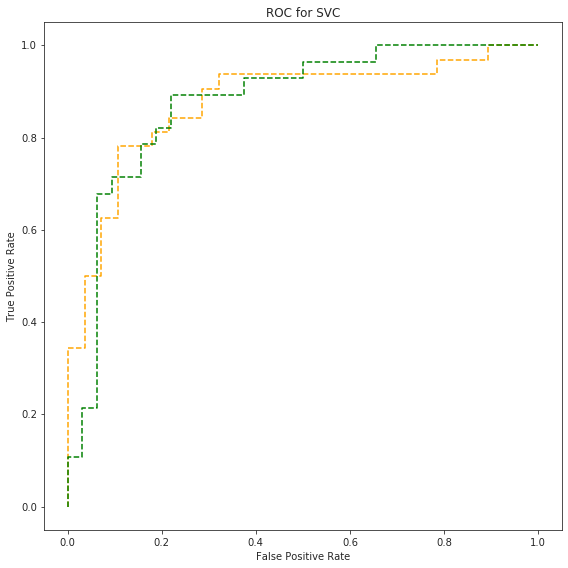

In [35]:
plot_roc(svm_result_2.best_estimator_.predict_proba(X_test), y_test, 'ROC for SVC', 2, colors, labels, (8, 8))

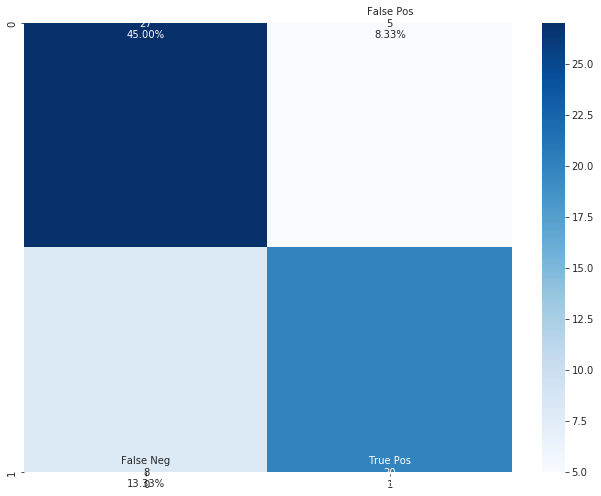

In [36]:
a = plot_confusion_matrix(confusion_matrix(y_test, svm_result_2.best_estimator_.predict(X_test)), (9, 7))

In [37]:
pred = pd.DataFrame()
pred['g_true'] = y_test
pred['pred'] = svm_result_2.best_estimator_.predict(X_test)
dif = []

for index, row in pred.iterrows():
    if row['g_true'] != row['pred']:
        dif.append(index)

pred.iloc[dif]

,g_true,pred
11,0,1
16,1,0
23,0,1
27,1,0
31,1,0
32,1,0
39,1,0
44,0,1
49,0,1
54,1,0


In [38]:
explainer_2 = LimeTabularExplainer(
    X_test,
    feature_names=X_test.columns, 
    class_names=['healthy', 'sick'], 
    discretize_continuous=False, 
    verbose=True
)

lime_2 = explainer_2.explain_instance(X_test.iloc[59], svm_result_2.best_estimator_.predict_proba)
lime_2.show_in_notebook(show_table=True)

Intercept 0.44378995267335125
Prediction_local [0.34976364]
Right: 0.3015229124201977
